In [1]:
import pymc as pm
import numpy as np
import pandas as pd

import path
from path import Path

## 0 Load data

### 0.1 Load training data

In [2]:
dir_root = Path.cwd().parent.parent
dir_root

Path('/Users/AnanyaPal1/Documents/TUD/5th semester/monte carlo simulations/bayesian-anomaly-and-fault-detection-in-sensor-data')

In [3]:
dir_train = dir_root / "data" / "train" / "X_train.txt"
dir_train_labels = dir_root / "data" / "train" / "y_train_mapped.txt"

In [4]:
X_train = pd.read_csv(dir_train,
                       header=None,
                       sep='\\s+',
                       index_col=None)
y_train = pd.read_csv(dir_train_labels,
                           header=None,
                           index_col=None)

In [5]:
X_train.shape

(7352, 561)

In [6]:
y_train.shape

(7352, 1)

### 0.2 Load test data

In [ ]:
dir_test = dir_root / "data" / "test" / "X_test.txt"
dir_train_labels = dir_root / "data" / "test" / "y_train_mapped.txt"

In [21]:
X_test = pd.read_csv(dir_test,
                       header=None,
                       sep='\\s+',
                       index_col=None)

In [22]:
X_test.shape

(2947, 561)

## 1 Dimensionality reduction with PCA

### 1.1 Train data

In [7]:
import sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_train_pca.shape

(7352, 30)

In [8]:
print(pca.explained_variance_ratio_.sum())

0.8906243704459997


In [11]:
pca_trial_1 = PCA(n_components=40)
X_train_pca_trial_1 = pca_trial_1.fit_transform(X_train)
X_train_pca_trial_1.shape

(7352, 40)

In [12]:
print(pca_trial_1.explained_variance_ratio_.sum())

0.9139440007141063


In [13]:
pca_trial_2 = PCA(n_components=50)
X_train_pca_trial_2 = pca_trial_2.fit_transform(X_train)
X_train_pca_trial_2.shape

(7352, 50)

In [14]:
print(pca_trial_2.explained_variance_ratio_.sum())

0.930863067076542


In [15]:
pca_trial_3 = PCA(n_components=100)
X_train_pca_trial_3 = pca_trial_3.fit_transform(X_train)
X_train_pca_trial_3.shape

(7352, 100)

In [16]:
print(pca_trial_3.explained_variance_ratio_.sum())

0.9730111912684988


### 1.2 Test data

In [23]:
X_test_pca = pca.transform(X_test)
X_test_pca.shape

(2947, 30)

## 2 PyMC Implementation

In [10]:
with pm.Model() as bayes_logreg:

    # Priors
    sigma_w = 1.0
    sigma_b = 1.0

    w = pm.Normal("w", mu=0.0, sigma=sigma_w, shape=X_train_pca.shape[1])
    b = pm.Normal("b", mu=0.0, sigma=sigma_b)

    # Linear predictor
    logits = pm.math.dot(X_train_pca, w) + b

    # Likelihood
    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

    # Inference
    trace = pm.sample(
        draws=500,
        tune=500,
        target_accept=0.9,
        chains=2,
        cores=1,
        random_seed=42,
        progressbar=True
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, b]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4751 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## 3 Diagnostics

In [17]:
import arviz as az

az.summary(trace, var_names=["w", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.000,0.000,-0.000,0.000,0.0,0.0,1608.0,916.0,1.00
w[1],-0.000,0.000,-0.000,0.000,0.0,0.0,867.0,845.0,1.00
w[2],0.000,0.000,-0.000,0.000,0.0,0.0,1166.0,652.0,1.00
w[3],-0.000,0.000,-0.001,0.000,0.0,0.0,928.0,722.0,1.01
w[4],-0.000,0.000,-0.001,0.000,0.0,0.0,1753.0,729.0,1.00
w[5],-0.000,0.000,-0.001,0.001,0.0,0.0,1334.0,659.0,1.00
w[6],-0.000,0.000,-0.001,0.001,0.0,0.0,1135.0,911.0,1.00
w[7],0.000,0.000,-0.001,0.001,0.0,0.0,1600.0,686.0,1.00
w[8],0.000,0.000,-0.001,0.001,0.0,0.0,1640.0,681.0,1.00
w[9],-0.000,0.000,-0.001,0.001,0.0,0.0,1584.0,987.0,1.00


array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

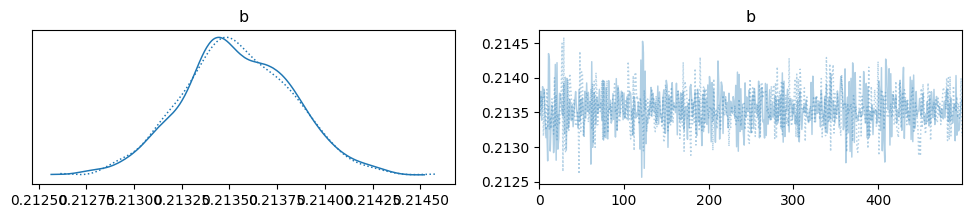

In [19]:
az.plot_trace(trace, var_names=["b"])


## 4 Posterior predictive probabilities on X_test

In [26]:
w_samples = trace.posterior["w"].stack(samples=("chain", "draw")).values
b_samples = trace.posterior["b"].stack(samples=("chain", "draw")).values

# Linear logits for test data
logits_test = X_test_pca @ w_samples + b_samples

# Sigmoid
p_test_samples = 1 / (1 + np.exp(-logits_test))
p_test_samples.shape #(expected: number of test samples, number of posterior samples)

(2947, 1000)

## 5 Predictive mean and credible intervals

In [28]:
p_mean = p_test_samples.mean(axis=1)
p_lower = np.percentile(p_test_samples, 5, axis=1)
p_upper = np.percentile(p_test_samples, 95, axis=1)

print(f"Mean posterior prediction: {p_mean}",)
print(f"Lower CI is: {p_lower} and upper CI is: {p_upper}")

Mean posterior prediction: [0.55318107 0.55319671 0.55318166 ... 0.55318889 0.55318097 0.55317274]
Lower CI is: [0.55237928 0.55250915 0.55269228 ... 0.55273867 0.55266064 0.55268734] and upper CI is: [0.55389141 0.55388695 0.55368817 ... 0.55365041 0.55373396 0.55365173]


## 6 Classification and evaluation

In [29]:
y_pred = (p_mean >= 0.5).astype(int)


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, p_mean)

print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC: {auc:.3f}")